In [38]:
import sys
import os
import pylab
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, ConnectionPatch 
from matplotlib import animation, rc
from IPython.display import HTML, Image

dir = os.path.dirname(os.path.realpath('__file__'))
pylab.rcParams['figure.figsize'] = (12.0, 12.0) #configure the figure

def deriv(y, t, L1, L2, m1, m2):
    """On renvoie les dérivées de y = theta1, theta1dot, theta2, theta2dot."""
    theta1, theta1dot, theta2, theta2dot = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot2 = (m2*g*np.sin(theta2)*c - m2*s*(L1*theta1dot**2*c + L2*theta2dot**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)

    theta2dot2 = ((m1+m2)*(L1*theta1dot**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) +
             m2*L2*theta2dot**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, theta1dot2, theta2dot, theta2dot2

def calc_Em(y):
    """Calcul de l'énergie mécanique du système"""

    theta1, theta1dot, theta2, theta2dot = y.T
    E_p = -(m1+m2)*L1*g*np.cos(theta1) - m2*L2*g*np.cos(theta2)
    E_c = 0.5*m1*(L1*theta1dot)**2 + 0.5*m2*((L1*theta1dot)**2 + (L2*theta2dot)**2 +
            2*L1*L2*theta1dot*theta2dot*np.cos(theta1-theta2))
    return E_c + E_p

## Paramètres du problème
- L1 : Longueur de la barre 1
- L2 : Longueur de la barre 2
- m1 : masse de la particule 1
- m2 : masse de la particule 2
- g : axccélération gravitationelle

In [39]:
# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 1, 1
m1, m2 = 1, 1
# The gravitational acceleration (m.s-2).
g = 9.81

## Calcul des positions

In [43]:
# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 10, 0.01
t = np.arange(0, tmax+dt, dt)
# Initial conditions: theta1, dtheta1/dt, theta2, dtheta2/dt.
y0 = np.array([3*np.pi/2, 0, 3*np.pi/4, 0])

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))

# Check that the calculation conserves total energy to within some tolerance.
EDRIFT = 0.05
# Total energy from the initial conditions
Em = calc_Em(y0)
if np.max(np.sum(np.abs(calc_Em(y) - Em))) > EDRIFT:
    sys.exit('Maximum energy drift of {} exceeded.'.format(EDRIFT))

# Unpack z and theta as a function of time
theta1, theta2 = y[:,0], y[:,2]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)

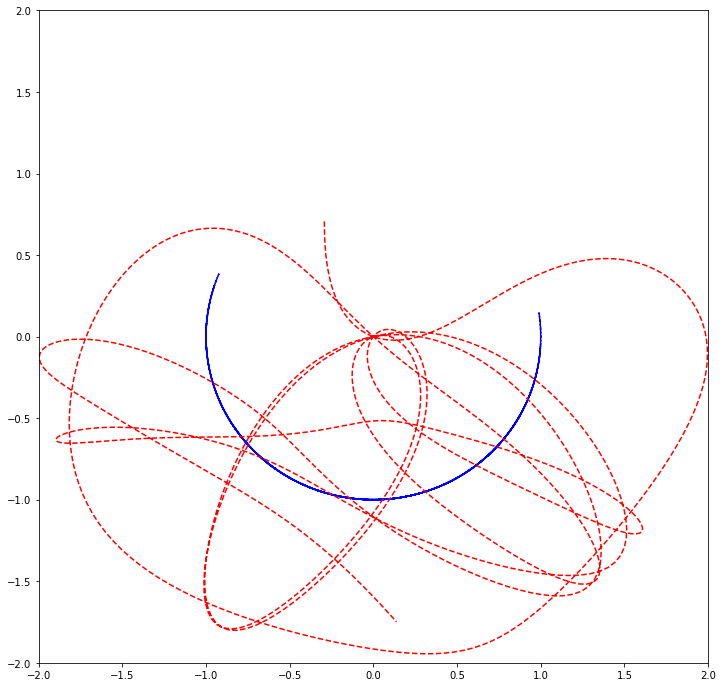

In [46]:
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
plt.plot(x1,y1, ls='--', c='b')
plt.plot(x2,y2, ls='--', c='r')

c0 = Circle((0, 0), r/2, fc='k', zorder=10)
c1 = Circle((x1[0], y1[0]), r, fc='b', ec='b', zorder=10)
c2 = Circle((x2[0], y2[0]), r, fc='r', ec='r', zorder=10)
c0.center = (0, 0)
c1.center = (x1[0], y1[0])
c2.center = (x2[0], y2[0])   
dotted_line1 = plt.Line2D((0., x1[0]), (0., y1[0]), lw=5., ls='-.', alpha=0.5)
dotted_line2 = plt.Line2D((x1[0], x2[0]), (y1[0], y2[0]), lw=5., ls='-.', alpha=0.5)
ax.add_patch(c0)
ax.add_patch(c1)    
ax.add_patch(c2)
ax.add_line(dotted_line1)
ax.add_line(dotted_line2)



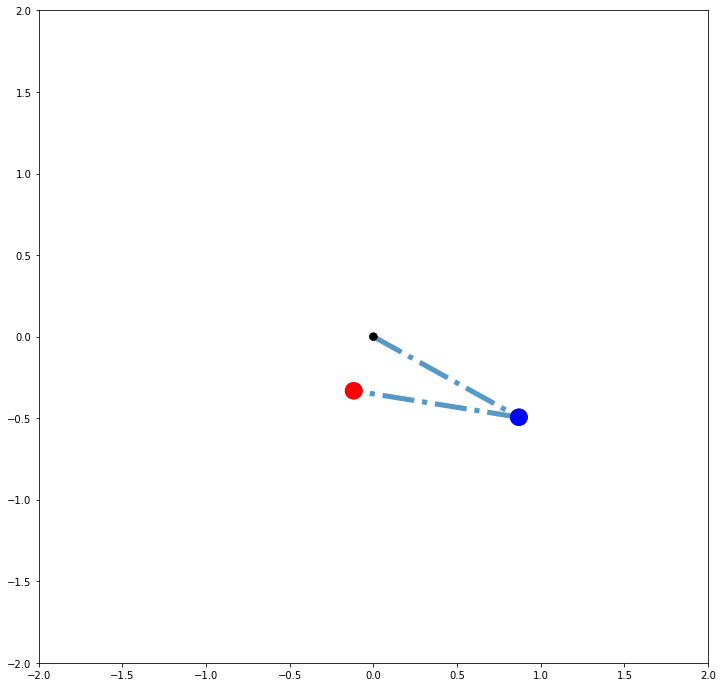

In [45]:
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
c0 = Circle((0, 0), r/2, fc='k', zorder=10)
c1 = Circle((x1[0], y1[0]), r, fc='b', ec='b', zorder=10)
c2 = Circle((x2[0], y2[0]), r, fc='r', ec='r', zorder=10)

#dotted_line = ml.Line2D((0.,0.), (x1[0], y1[0]), lw=5., ls='-.', markerfacecolor='r', markeredgecolor='r', alpha=0.5)
#dotted_line2 = ml.Line2D((x1[0], y1[0]), (x2[0], y2[0]), lw=5., ls='-.', markerfacecolor='r', markeredgecolor='r', alpha=0.5)

fps = 10
di = int(1/fps/dt)

dotted_line1 = plt.Line2D((0., x1[0]), (0., y1[0]), lw=5., ls='-.', alpha=0.5)
dotted_line2 = plt.Line2D((x1[0], x2[0]), (y1[0], y2[0]), lw=5., ls='-.', alpha=0.5)

def init():
    c0.center = (0, 0)
    c1.center = (x1[0], y1[0])
    c2.center = (x2[0], y2[0])    
    ax.add_patch(c0)
    ax.add_patch(c1)    
    ax.add_patch(c2)
    ax.add_line(dotted_line1)
    ax.add_line(dotted_line2)
    
    data = []
    data.append(c0)
    data.append(c1)
    data.append(c2)    
    data.append(dotted_line1)
    data.append(dotted_line2)      
    return data

def animate(i):
    c0.center = (0, 0)
    c1.center = (x1[i], y1[i])
    c2.center = (x2[i], y2[i])    
    dotted_line1.set_xdata((0., x1[i]))
    dotted_line1.set_ydata((0., y1[i]))    
    dotted_line2.set_xdata((x1[i], x2[i]))
    dotted_line2.set_ydata((y1[i], y2[i]))
    
    data = []
    data.append(c0)
    data.append(c1)
    data.append(dotted_line1)
    data.append(dotted_line2)           
    return data

anim = animation.FuncAnimation(fig, animate, 
                               init_func=init, 
                               frames=360, 
                               interval=200.,
                               blit=True)

#plt.axis('scaled')
anim.save('basic_animation.gif', writer='imagemagick', fps=30)
#anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:
#HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())
Image(url='basic_animation.gif')